# LDA Topic Modeling

This notebook focuses on topic modeling using the Latent Dirichlet Allocation (LDA) method.

## Imports

In [1]:
import pandas as pd
from tqdm import tqdm  
import numpy as np
import nltk
import copy
import pickle
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize
import random

## Data Loading

In [6]:
data = pd.read_csv("../data/processed_data/data_full_processed.csv", sep=",")

In [30]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

## Data Preprocessing


### Tokenization & Filtering

In [7]:
# new column with tokenized abstract
data["tokenized_abstract"] = data["processed_abstract"].apply(word_tokenize)
tokens = data["tokenized_abstract"].tolist()

# pos tagging to the tokenized words
pos_tagged_tokens = []
for token in tqdm(tokens):
    pos_tagged_tokens.append(nltk.pos_tag(token))

# keep only the nouns
nouns_verbs = []
for pos_tagged_token in tqdm(pos_tagged_tokens):
    nouns_verbs.append([token[0] for token in pos_tagged_token if token[1] in ["NN", "NNS", "NNP", "NNPS"]])

# remove tokens that are less than 2 characters
tokens = [[token for token in noun if len(token) > 2] for noun in nouns_verbs]

100%|██████████| 363/363 [00:00<00:00, 52939.23it/s]


### Bigrams

In [8]:
bigram_measures = nltk.collocations.BigramAssocMeasures() 
finder = BigramCollocationFinder.from_documents(tokens) 

# only bigrams that appear 5+ times (after several trials, 5 was the best number)
finder.apply_freq_filter(5) 

# return the 100 bigrams with the highest PMI
mwt = finder.nbest(bigram_measures.dice, 100) 

In [9]:
def collapse_tokens(token_list, mwt):
    '''
        This function takes a list of tokens and collapses the multi-word tokens (MWTs) into a single token.
    
        Parameters:
            token_list (list): A list of tokens
            mwt (list): A list of multi-word tokens

        Returns:
            res_token (list): A list of tokens with MWTs collapsed
    '''
    token_list = copy.copy(token_list)
    res_token = []
    while(len(token_list)>1):
        if (token_list[0],token_list[1]) in mwt:
            res_token.append(f'{token_list.pop(0)}_{token_list.pop(0)}')
        else:
            res_token.append(token_list.pop(0))
    
    if len(token_list) == 1:
        res_token.append(token_list.pop(0))

    return res_token

In [10]:
coll_tokens = [collapse_tokens(token_list, mwt) for token_list in tqdm(tokens)]

100%|██████████| 363/363 [00:00<00:00, 12469.55it/s]

In [11]:
def cv_token_return(doc):
    return doc

In [12]:
wordvect = CountVectorizer(analyzer="word", strip_accents='ascii',preprocessor=cv_token_return, tokenizer=cv_token_return, min_df=3) 
dtm = wordvect.fit_transform(coll_tokens) 

/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
data = zip(wordvect.get_feature_names_out(),
    np.asarray(dtm.sum(axis=0)).ravel())

df = pd.DataFrame(data, columns =['Word', 'Frequency'])
df.sort_values(by=['Frequency'], inplace=True, ascending=False)
print(df)

              Word  Frequency
94            data        123
423         system        102
315          power         98
77     consumption         82
244     management         62
..             ...        ...
155       facility          3
80    contribution          3
245  manufacturers          3
69       component          3
455      treatment          3

[499 rows x 2 columns]


## DTM

In [14]:
vocab = df.Word.to_list()[20:] # ignore the top 20 words

wordvect = CountVectorizer(vocabulary = vocab, analyzer="word", strip_accents='ascii',preprocessor=cv_token_return, tokenizer=cv_token_return, min_df=3, stop_words="english", max_df=0.98)
dtm = wordvect.fit_transform(coll_tokens)

/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


## LDA

In [20]:
for i in range(10):
    lda_model = LatentDirichletAllocation(n_components=6, # Number of topics
                                        max_iter=250, # Max learning iterations
                                        learning_method='batch',   
                                        random_state=100+i, # Random state
                                        batch_size=128,  # n docs in each learning iter
                                        evaluate_every = 10, # compute perplexity every n iters, default: Don't
                                        n_jobs = -1, # Use all available CPUs
                                        )

    lda_output = lda_model.fit_transform(dtm)
    pickle.dump(lda_model, open(f"../results/lda_output/lda_model_{i}.pkl", "wb"))
    pickle.dump(lda_output, open(f"../results/lda_output/lda_output_{i}.pkl", "wb"))

# lda_output # document-topic matrix (document x topic)
# lda_model.components_ # topic-term matrix (topic x term) 

In [21]:
# obj0, obj1, obj2 are created here...
pickle.dump(wordvect, open("../results/lda_output/wordvect.pickel", "wb"))
pickle.dump(dtm, open("../results/lda_output/dtm.pickel", "wb"))

## Topics

In [22]:
def show_topics(vectorizer=wordvect, lda_model=lda_model, n_words=14):
    ''' 
        This function returns the top n keywords for each topic in a dataframe.

        Parameters:
            vectorizer (CountVectorizer): A CountVectorizer object
            lda_model (LatentDirichletAllocation): A LatentDirichletAllocation object
            n_words (int): The number of keywords to return for each topic

        Returns:
            topic_keywords (list): A list of the top n keywords for each topic
    '''
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [23]:
topic_keywords = show_topics(vectorizer=wordvect, lda_model=lda_model, n_words=15)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,technologies,demand,performance,economy,internet,electricity,techniques,equipment,innovation,solutions,building,architecture,policy,operations,infrastructure
Topic 1,detection,time,wind,strategy,environment,impact,sources,datasets,buildings,factors,problem,features,comfort,fault,things
Topic 2,industry,intelligence,electricity,information,home,value,operation,solutions,software,methodology,simulation,operations,issues,intelligent,cost
Topic 3,analysis,research,methods,efficiency,load,waste,tools,framework,solution,data_data,approach,plant,electricity,manufacturing,grids
Topic 4,networks,communication,machine,process,grid,generation,optimization,panels,challenges,materials,approach,sources,resource,wireless,load
Topic 5,city,sensor,cities,resources,life,building,inference,tasks,detection,health,quality,monitoring,computation,method,vehicle


## Silhouette Score

In [25]:
from sklearn.metrics import silhouette_score

silhouette_scores = []  
# read the lda_output saved (lda_output_{i}.pkl) from 1 to 10
for i in range(0,10):
    lda_output = pd.read_pickle(f'../results/lda_output/lda_output_{i}.pkl')

    topic_assignments = np.argmax(lda_output, axis=1)
    silhouette = silhouette_score(dtm, topic_assignments)
    silhouette_scores.append(silhouette)

silhouette_score = np.mean(silhouette_scores)
print(f"Silhouette Score: {silhouette_score}")


Silhouette Score: -0.019330858109786686


## LDA Visualization

In [26]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

pyLDAvis.lda_model.prepare(lda_model, dtm, wordvect)

/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.082152  0.183704       1        1  18.774193
0     -0.066117 -0.048879       2        1  17.918690
4      0.238694 -0.083525       3        1  17.258059
3     -0.069393 -0.066633       4        1  16.088127
1      0.086570  0.148439       5        1  15.863648
2     -0.107602 -0.133107       6        1  14.097284, topic_info=              Term       Freq      Total Category  logprob  loglift
1     technologies  36.000000  36.000000  Default  30.0000  30.0000
4         networks  32.000000  32.000000  Default  29.0000  29.0000
5             city  31.000000  31.000000  Default  28.0000  28.0000
8    communication  30.000000  30.000000  Default  27.0000  27.0000
18          sensor  27.000000  27.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
61          output   6.406410  15.226080   Topic6  -4.5459   1.0935
52        platform   6.401536  16.211733   Topic6  -4.5467   1.0300
40        learning   6.674863  18.847985   Topic6  -4.5049   0.9211
102       vehicles   5.361290  11.689639   Topic6  -4.7240   1.1797
86        business   5.508571  13.495236   Topic6  -4.6969   1.0632

[305 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
114       1  0.092911           accuracy
114       4  0.278732           accuracy
114       6  0.557464           accuracy
362       4  0.667631         advantages
362       5  0.222544         advantages
...     ...       ...                ...
237       1  0.159049  wireless_networks
237       5  0.795246  wireless_networks
111       1  0.644605              world
111       4  0.184173              world
111       5  0.184173              world

[531 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 5, 4, 2, 3])

## Wordclouds


Topic#  1
technologies,demand,performance,economy,internet,electricity,techniques,equipment,innovation,solutions,building,architecture,policy,operations,infrastructure,strategy,buildings,research,fashion,grids,dsm,protection,supply_chain,vision,step



/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  2
detection,time,wind,strategy,environment,impact,sources,datasets,buildings,factors,problem,features,comfort,fault,things,speed,architecture,problems,mec,reinforcement,theory,processing,predictions,defects,field



/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  3
industry,intelligence,electricity,information,home,value,operation,solutions,software,methodology,simulation,operations,issues,intelligent,cost,gas,learning,output,power_grid,university,platform,status,smart,accuracy,values

Topic#  4
analysis,research,methods,efficiency,load,waste,tools,framework,solution,data_data,approach,plant,electricity,manufacturing,grids,distribution,temperature,students,consumer,demand,stability,buildings,error,enterprises,platforms



/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  5
networks,communication,machine,process,grid,generation,optimization,panels,challenges,materials,approach,sources,resource,wireless,load,machine_learning,optimisation,distribution,concepts,architecture,scenario,parameters,studies,engineering,learning



/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  6
city,sensor,cities,resources,life,building,inference,tasks,detection,health,quality,monitoring,computation,method,vehicle,framework,results,countries,community,architecture,use,reliability,data_data,image,allocation



/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


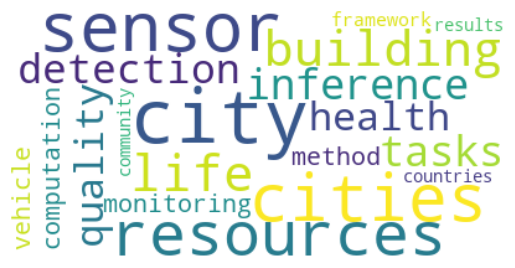

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

terms_count = 25
terms = wordvect.get_feature_names_out()

for idx,topic in enumerate(lda_model.components_):    
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}
    
    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]    
    wcloud = WordCloud(background_color="white",mask=None, max_words=100,\
                        max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                        contour_width=3,contour_color='black')
    wcloud.generate_from_frequencies(dict_word_frequency)       
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig("../figures/LDA/Topic#"+str(idx+1)+".png", format="png")

## Topic Analysis


In [28]:
#Time series
topic_labels = []

for index, row in df_topic_keywords.iterrows():
    topic_labels.append('.'.join(row[0:5].to_list()))

print(topic_labels) # labels for each topic

['technologies.demand.performance.economy.internet', 'detection.time.wind.strategy.environment', 'industry.intelligence.electricity.information.home', 'analysis.research.methods.efficiency.load', 'networks.communication.machine.process.grid', 'city.sensor.cities.resources.life']


In [30]:
data = pd.read_csv("../data/processed_data/data_full_processed_with_date.csv", sep=",")
my_sample = random.sample(range(1, len(data)), 3)

print(data.abstract[my_sample[0]] + "\n")
print(data.abstract[my_sample[1]] + "\n")
print(data.abstract[my_sample[2]] + "\n")

Future's Educational small and medium enterprises (SMEs) which are super intelligent learning with smart business education environment by using future of 4th technologies, Internet of Thing (IoT), Artificial Intelligence (AI), digitalization and sustainability. These technologies would create smart education; however, barriers cause challenges to apply these technologies and create modern areas like e-learning and MOOCs. It is required to indicate these barriers and find out solutions to apply them and change humans' life to maintain the world. In this paper we will introduce the DOOST SME RANKING (DSRM) Model invented by Prof. Doost, through the 5th wave theory as solutions for Educational SMEs Development and learning and educational concerns in the future of 4th industrial revolution. In other words, this paper is a picture of the current business project environment in Educational SMEs Ranking. One of the primary objectives of this research is to allow educational actors, managers

In [31]:
vizDataFrame = pd.DataFrame({'Text_1': lda_output[my_sample[0],], 
                             'Text_2': lda_output[my_sample[1],],
                             'Text_3': lda_output[my_sample[2],]})

vizDataFrame.index = topic_labels

vizDataFrame

,Text_1,Text_2,Text_3
technologies.demand.performance.economy.internet,0.014075,0.008345,0.009285
detection.time.wind.strategy.environment,0.013963,0.008340,0.009290
industry.intelligence.electricity.information.home,0.013928,0.958257,0.431551
analysis.research.methods.efficiency.load,0.930140,0.008377,0.454978
networks.communication.machine.process.grid,0.013897,0.008348,0.009317
city.sensor.cities.resources.life,0.013997,0.008333,0.085579


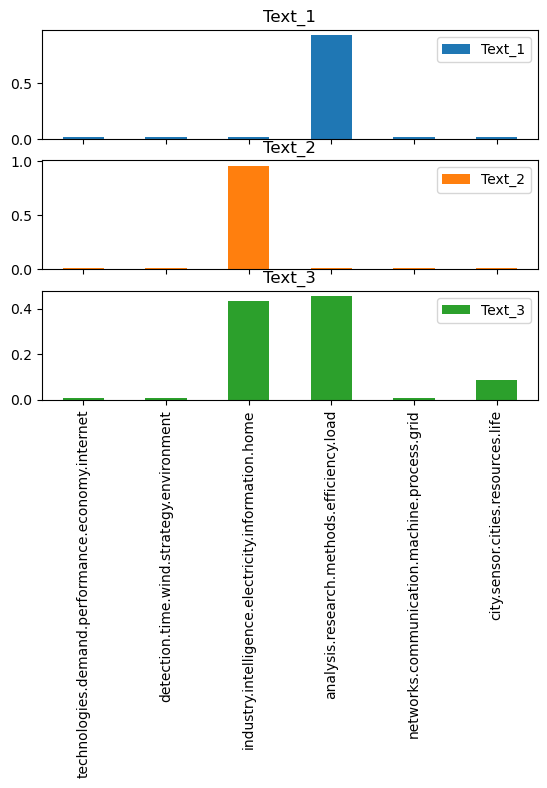

In [32]:
axes = vizDataFrame.plot.bar(rot=90, subplots=True)
axes[1].legend(loc=None) 

In [33]:
#Topic Importance
topicProportions = np.sum(lda_output, axis=0)/lda_output.shape[0]
topicProportions_df = pd.DataFrame({'Topic': topic_labels, 'Mean_Prob': topicProportions})
topicProportions_df.sort_values(by=['Mean_Prob'], inplace=True, ascending=False)
# Print the DataFrame
print(topicProportions_df)

                                               Topic  Mean_Prob
4        networks.communication.machine.process.grid   0.183815
0   technologies.demand.performance.economy.internet   0.181316
5                  city.sensor.cities.resources.life   0.165905
1           detection.time.wind.strategy.environment   0.164723
3          analysis.research.methods.efficiency.load   0.158608
2  industry.intelligence.electricity.information....   0.145632


In [34]:
#Rank-1 Method
num_topics = 6

countsOfPrimaryTopics = np.zeros(num_topics)

for row in lda_output:
    important_topic = (np.argsort(row)[::-1])[0]
    countsOfPrimaryTopics[important_topic] += 1

topicProportions_df_rank_1 = pd.DataFrame({'Topic': topic_labels, 'Count': countsOfPrimaryTopics})
topicProportions_df_rank_1.sort_values(by=['Count'], inplace=True, ascending=False)
# Print the DataFrame
print(topicProportions_df_rank_1)

                                               Topic  Count
4        networks.communication.machine.process.grid   69.0
5                  city.sensor.cities.resources.life   63.0
0   technologies.demand.performance.economy.internet   62.0
1           detection.time.wind.strategy.environment   61.0
3          analysis.research.methods.efficiency.load   56.0
2  industry.intelligence.electricity.information....   52.0


/var/folders/tr/11z_m_bn5pxg8m0m7762nzl00000gn/T/ipykernel_14044/1192423461.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral')


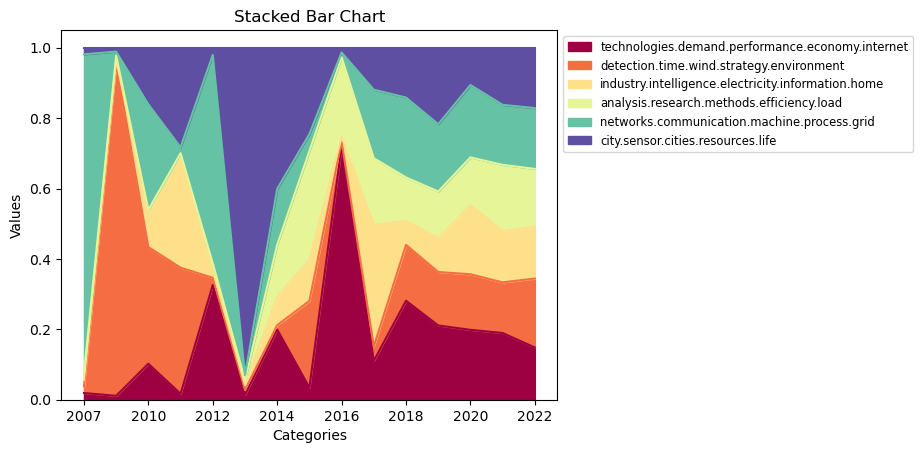

In [38]:
#document distribution over time
import string
from matplotlib import cm

cmap = cm.get_cmap('Spectral')
data["year"] = data['year'].astype(str)

# Combine the 2D array with the DataFrame column using Pandas' concat function
combined_array = pd.concat([pd.DataFrame(lda_output, columns=topic_labels), data["year"]], axis=1)
aggregated_data = combined_array.groupby('year').mean().reset_index()
aggregated_data.set_index('year', inplace=True)

# Create a stacked bar chart
aggregated_data.plot.area(stacked=True,colormap=cmap, legend='reverse').legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',

)

# Optional: Customize the plot
import matplotlib.pyplot as plt

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Stacked Bar Chart')
plt.savefig('../figures/LDA/stacked_bar_chart.png')
plt.show()
